In [1]:
# import packages
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS

# seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn
from sklearn.preprocessing import LabelEncoder

# warnings
import warnings
warnings.filterwarnings('ignore')

#mapping
import folium
from folium import FeatureGroup, plugins, LayerControl
import geojson 
import geopandas as gpd

# tqdm
from tqdm import tqdm

# datapane
import datapane as dp

C:\Users\hsin\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import data 
# the earliest crash data was as of 1 January 2016
# the latest crash data was as of 31 December 2020 thus there is FIVE years' worth of data in here
crash = pd.read_csv('Traffic_Crashes_-_Crashes.csv') #make daeetime the index
vehicles = pd.read_csv('Traffic_Crashes_-_Vehicles.csv').drop('CRASH_DATE', axis=1)

In [3]:
# merge the two datasets on CRASH_RECORD_ID
df = pd.merge(crash,vehicles,on='CRASH_RECORD_ID')

df['CRASH_DATE'] = df['CRASH_DATE'].apply(pd.to_datetime)
df = df.set_index('CRASH_DATE')

In [9]:
df.index.day_name()

Index(['Monday', 'Monday', 'Monday', 'Monday', 'Sunday', 'Sunday', 'Saturday',
       'Saturday', 'Monday', 'Monday',
       ...
       'Saturday', 'Friday', 'Friday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object', name='CRASH_DATE', length=950955)

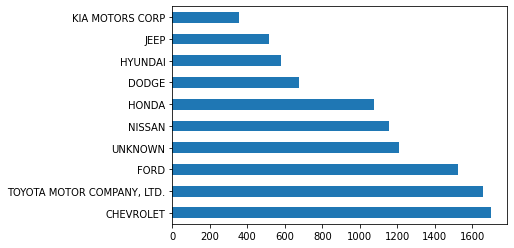

In [4]:
# the make of the vehicle involved in the most daylight crashes in August 2018.
daylight = df[df['LIGHTING_CONDITION'] == 'DAYLIGHT']

daylight.loc['2018-08']['MAKE'].value_counts()[:10].plot.barh();

In [5]:
prevalent_weather = pd.DataFrame(df.groupby('FIRST_CRASH_TYPE')['WEATHER_CONDITION'].apply(lambda x: x.value_counts()[:1])).reset_index()\
.rename(columns={'level_1': 'WEATHER_CONDITION', 'WEATHER_CONDITION':'COUNT' })
                    
prevalent_weather

FIRST_CRASH_TYPE WEATHER_CONDITION   COUNT
0                          ANGLE             CLEAR   81684
1                         ANIMAL             CLEAR     330
2                   FIXED OBJECT             CLEAR   17306
3                        HEAD ON             CLEAR    6630
4             OTHER NONCOLLISION             CLEAR    1319
5                   OTHER OBJECT             CLEAR    3988
6                     OVERTURNED             CLEAR     228
7           PARKED MOTOR VEHICLE             CLEAR  176425
8                   PEDALCYCLIST             CLEAR   12320
9                     PEDESTRIAN             CLEAR   17392
10                      REAR END             CLEAR  187052
11                 REAR TO FRONT             CLEAR    4236
12                  REAR TO REAR             CLEAR     978
13                  REAR TO SIDE             CLEAR    2596
14  SIDESWIPE OPPOSITE DIRECTION             CLEAR   11653
15      SIDESWIPE SAME DIRECTION             CLEAR  123552
16                         TRAIN             CLEAR      46
17                       TURNING             CLEAR  108455

In [6]:
df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

UNABLE TO DETERMINE                                                                 347204
FAILING TO YIELD RIGHT-OF-WAY                                                       106430
FOLLOWING TOO CLOSELY                                                               105048
NOT APPLICABLE                                                                       48895
IMPROPER OVERTAKING/PASSING                                                          45535
FAILING TO REDUCE SPEED TO AVOID CRASH                                               43163
IMPROPER BACKING                                                                     40835
IMPROPER LANE USAGE                                                                  37479
IMPROPER TURNING/NO SIGNAL                                                           31500
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  28684
DISREGARDING TRAFFIC SIGNALS                                                         17958

In [7]:
# plot the trend of the injuries over last 7 years
crash_time = crash.copy()
crash_time['CRASH_DATE'] = crash_time['CRASH_DATE'].apply(pd.to_datetime) # make CRASH_DATE a datetime object
crash_time = crash_time.set_index('CRASH_DATE') # arrange the data so that CRASH_DATE is the index

 # lets see the yearly trend of these stats
crash_plots = ['INJURIES_TOTAL','INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING']

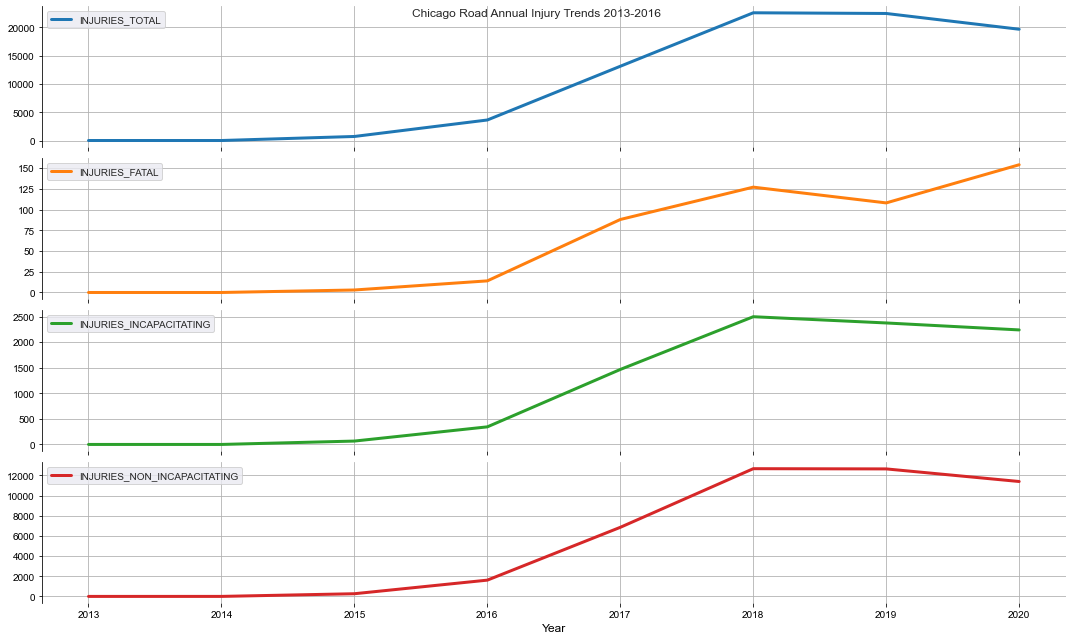

In [8]:
# plotting the trend for each of those stats
fig, ax = plt.subplots(4,1, figsize=(15,9), sharex=True)
sns.set_style('darkgrid')
crash_time.groupby(crash_time.index.year)[crash_plots].sum().plot(figsize=(11,9), subplots=True, ax=ax, lw=3, ls='-')
plt.suptitle('Chicago Road Annual Injury Trends 2013-2016')
sns.despine(bottom=True, right=True)
plt.xlabel('Year', fontsize=12)
plt.tight_layout();
fig.savefig('Annual Injury Trends.jpg')

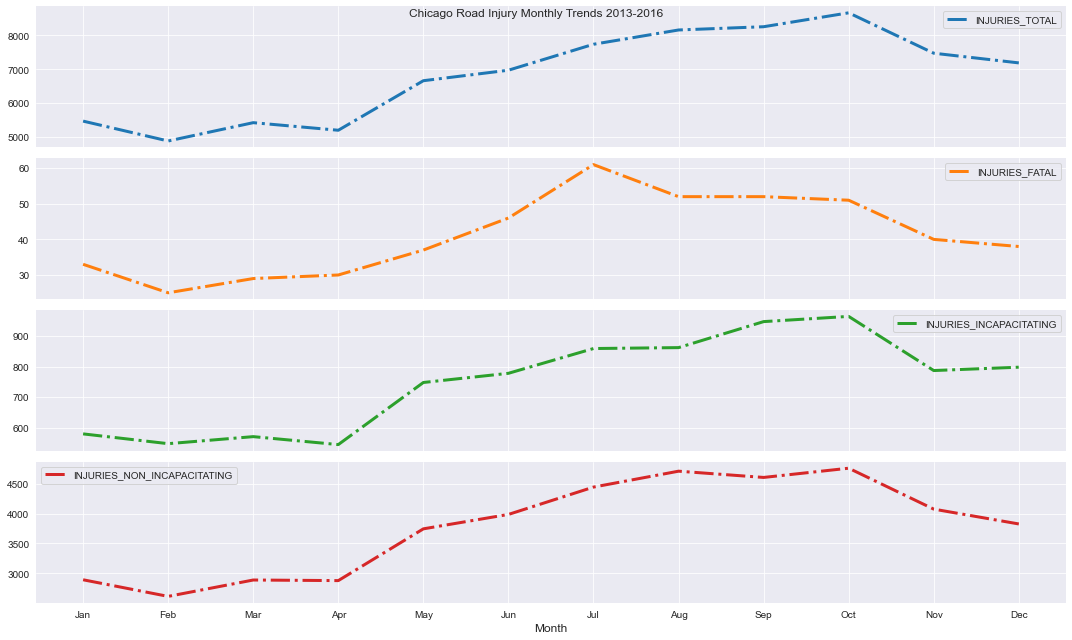

In [9]:
# plotting the trend for each of those stats
fig, ax = plt.subplots(4,1, figsize=(15,9), sharex=True)

crash_time.groupby(crash_time.index.month)[crash_plots].sum().plot(figsize=(11,9), subplots=True, ax=ax, linewidth=3, ls='-.')
plt.suptitle('Chicago Road Injury Monthly Trends 2013-2016')
sns.despine(left=True, bottom=True, right=True)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] # set up list of months for ticks
plt.xticks(np.arange(1,13), labels=months)

plt.xlabel('Month', fontsize=12)
plt.tight_layout();
fig.savefig('Monthly Injury Trends')

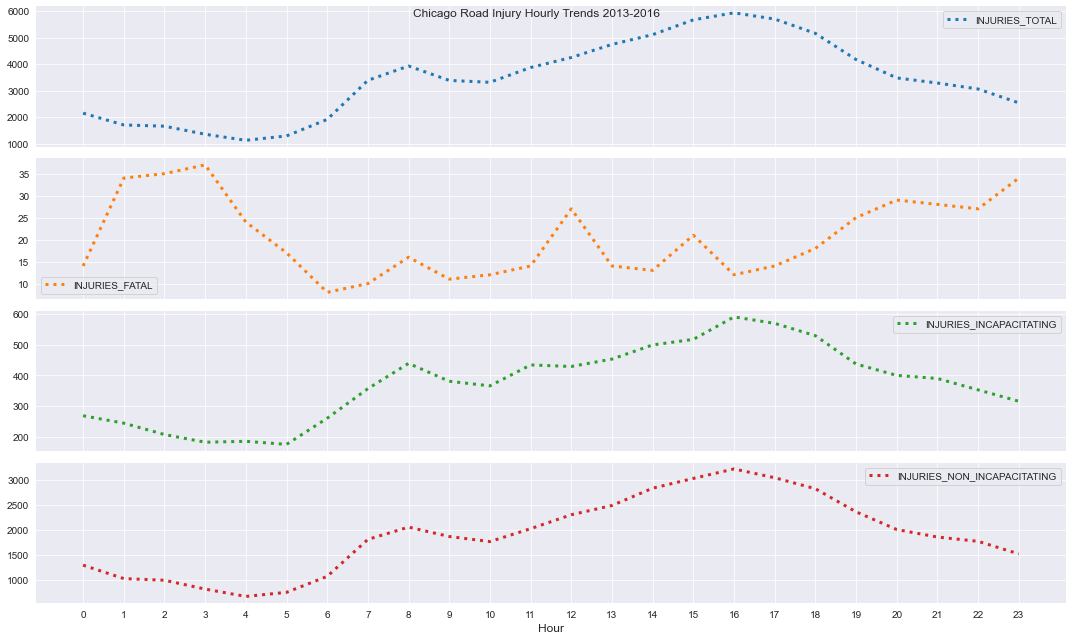

In [10]:
# plotting the trend for each of those stats
fig, ax = plt.subplots(4,1, figsize=(15,9), sharex=True)

crash_time.groupby(crash_time.index.hour)[crash_plots].sum().plot(figsize=(11,9), subplots=True, ax=ax, linewidth=3, ls=':')
plt.suptitle('Chicago Road Injury Hourly Trends 2013-2016')
sns.despine(left=True, bottom=True, right=True)
plt.xlabel('Hour', fontsize=12)
plt.xticks(np.arange(0,24))
plt.tight_layout();
fig.savefig('Hourly Injury Trends')

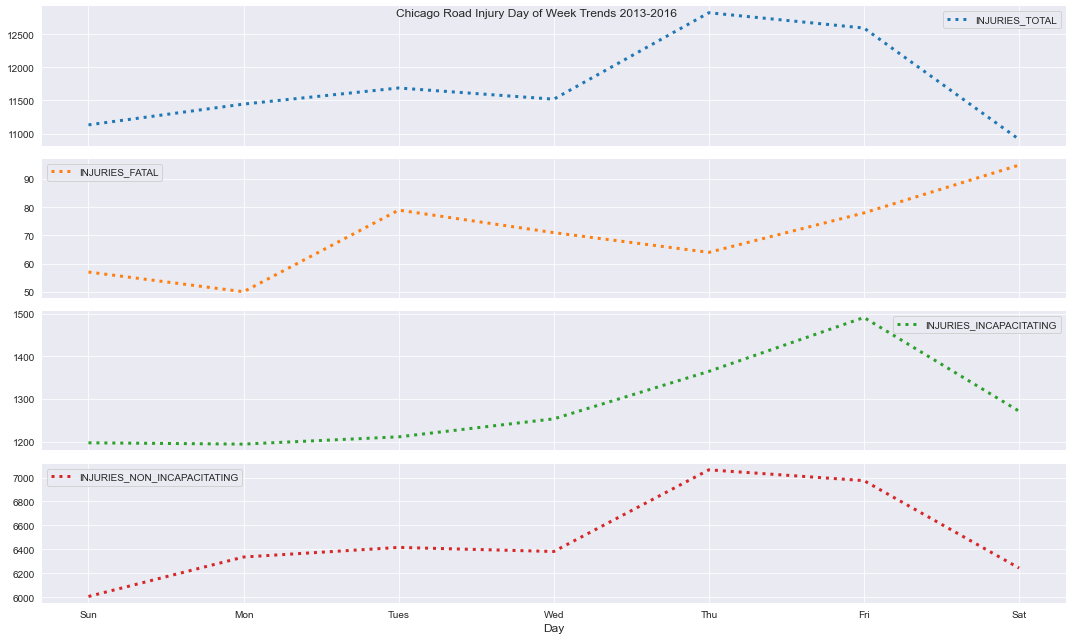

In [11]:
# plotting the trend for each of those stats
fig, ax = plt.subplots(4,1, figsize=(15,9), sharex=True)

crash_time.groupby(crash_time.index.weekday)[crash_plots].sum().plot(figsize=(11,9), subplots=True, ax=ax, linewidth=3, ls=':')
plt.suptitle('Chicago Road Injury Day of Week Trends 2013-2016')
sns.despine(left=True, bottom=True, right=True)
plt.xlabel('Day', fontsize=12)
days = ['Sun','Mon','Tues','Wed','Thu','Fri','Sat'] #set day names for x-axis
plt.xticks(np.arange(0,7), labels=days)
plt.tight_layout();
fig.savefig('Day of Week Injury Trends')

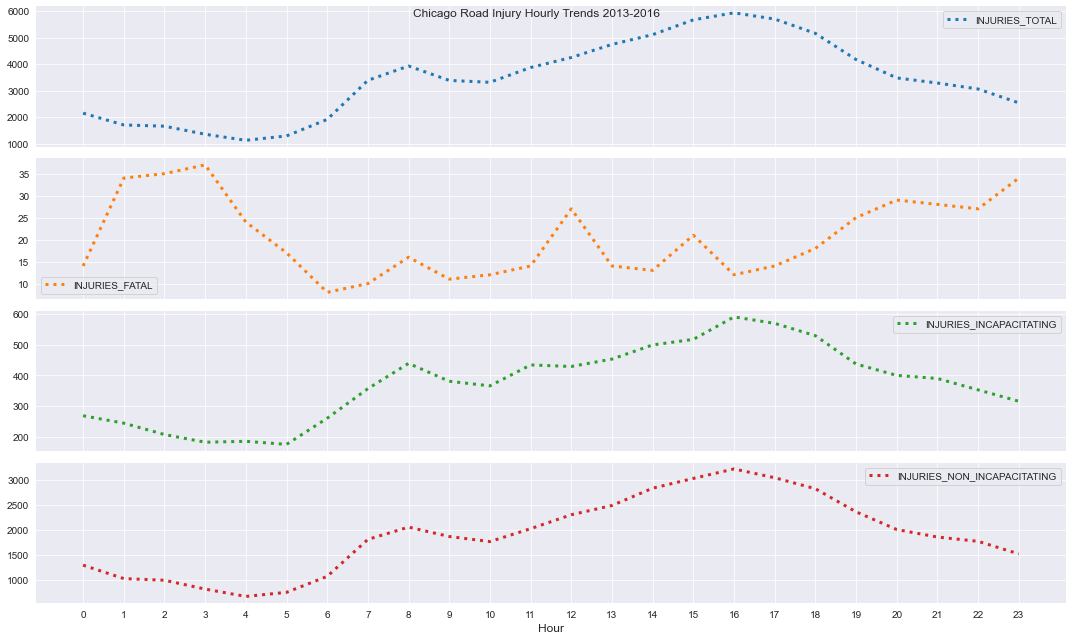

In [12]:
# plotting the trend for each of those stats
fig, ax = plt.subplots(4,1, figsize=(15,9), sharex=True)

crash_time.groupby(crash_time.index.hour)[crash_plots].sum().plot(figsize=(11,9), subplots=True, ax=ax, linewidth=3, ls=':')
plt.suptitle('Chicago Road Injury Hourly Trends 2013-2016')
sns.despine(left=True, bottom=True, right=True)
plt.xlabel('Hour', fontsize=12)
plt.xticks(np.arange(0,24))
plt.tight_layout();
fig.savefig('Hourly Injury Trends')

In [13]:
crash['MOST_SEVERE_INJURY'].unique()

array(['NO INDICATION OF INJURY', 'NONINCAPACITATING INJURY',
       'REPORTED, NOT EVIDENT', 'INCAPACITATING INJURY', 'FATAL', nan],
      dtype=object)

In [14]:
# focus on causes
causes= crash[['PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE']]

cols = {'PRIM_CONTRIBUTORY_CAUSE':'Primary','SEC_CONTRIBUTORY_CAUSE':'Secondary'}
causes.rename(columns=cols, inplace=True)

cause_type = list(causes['Primary'].unique())
sec_cause_type = list(causes['Secondary'].unique())

set(cause_type) == set(sec_cause_type) #both Primary and Secondary causes have exactly the same values

labelencoder = LabelEncoder()

causes['Primary_cat'] = labelencoder.fit_transform(causes['Primary'])
causes['Secondary_cat'] = labelencoder.fit_transform(causes['Primary'])
causes_cat = causes[['Primary_cat','Secondary_cat']]

causes[causes['Primary_cat'] != causes['Secondary_cat']] #wow primary and secondary causes in this dataframe are the same in each case

Empty DataFrame
Columns: [Primary, Secondary, Primary_cat, Secondary_cat]
Index: []

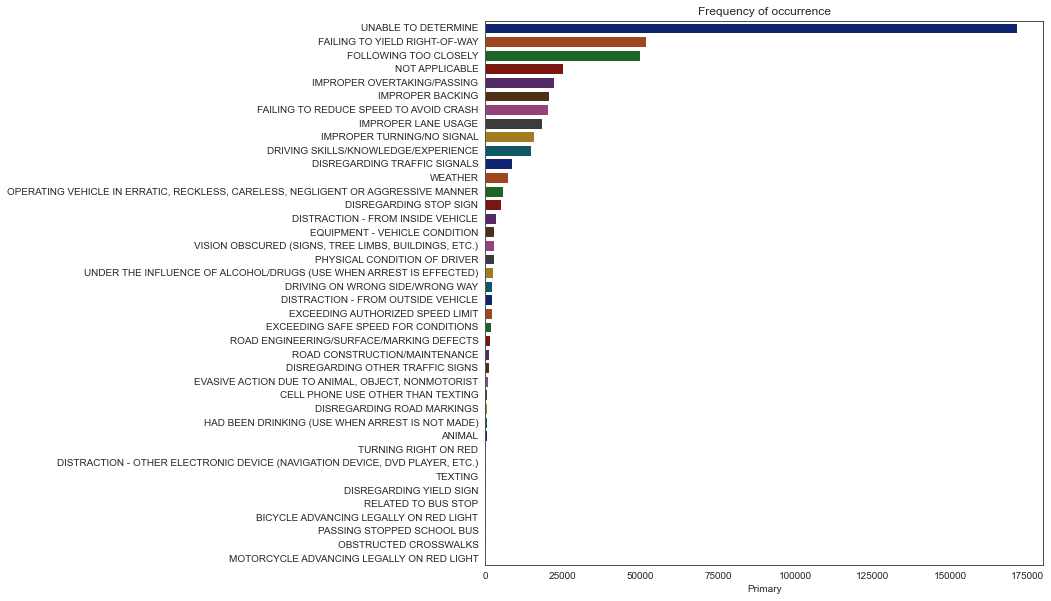

In [15]:
# focus on causes
causes_freq= crash[['PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE']]

cols = {'PRIM_CONTRIBUTORY_CAUSE':'Primary','SEC_CONTRIBUTORY_CAUSE':'Secondary'}
causes_freq.rename(columns=cols, inplace=True)

prim_cause_df = pd.DataFrame(causes_freq['Primary'].value_counts())

sns.set_style('white')
plt.figure(figsize=(10,10))
plt.title('Frequency of occurrence')
ax = sns.barplot(y=prim_cause_df.index,x='Primary',data=prim_cause_df, palette='dark')

In [16]:
#load geojson downloaded from city of chicago crashsite

with open('police_beats.geojson','r') as file:
    tmp = json.load(file)

# coords are the coordinates of each data point
# this is taken from the dataset pre-clean up
lat = crash['LATITUDE']
lon = crash['LONGITUDE']
coords = list(zip(lat,lon))

# create list of unique beats in the dataset
data_beat = list(set(crash.BEAT_OF_OCCURRENCE))

# create a list geobeats with from the beat IN THE JSON that are ALSO in data_beat
geobeats = list(set([int(tmp['features'][x]['properties']['beat_num']) for x in range(len(tmp['features'])) if int(tmp['features'][x]['properties']['beat_num']) in data_beat]))

# remove beats not in our dataset
req_beats = [tmp['features'][x] for x in range(len(tmp['features'])) if int(tmp['features'][x]['properties']['beat_num']) in geobeats]

# convert 'beat_num' in the nested JSON to float
# this is needed to match with the key BEAT_OF_OCCURRENCE - which is also a float
for x in range(len(req_beats)):
    req_beats[x]['properties']['beat_num'] = float(req_beats[x]['properties']['beat_num'])
    
# create new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = req_beats

# save the new JSON object as updated_json
open('updated_json.json','w').write(json.dumps(new_json, sort_keys=True, separators=(',',':')))

# instantiate map
mp = folium.Map(location=coords[100], zoom_start=10, tiles='cartodbpositron')

# add fatality choropleth
table = pd.DataFrame(crash.groupby('BEAT_OF_OCCURRENCE')['INJURIES_FATAL'].sum().reset_index())
choropleth =  folium.Choropleth(geo_data='updated_json.json', data=table, 
              columns = ['BEAT_OF_OCCURRENCE','INJURIES_FATAL'], 
              key_on= 'feature.properties.beat_num',
              bins = 8,
              fill_color= 'YlOrRd', 
              fill_opacity = 0.4,
              line_opacity = 0.3,
              line_color= 'black',
              legend_name = 'Fatalities',
              name = 'Total Fatalities',
              show=True,
              highlight= True).add_to(mp)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['beat_num'], labels=True))

# add all injuries choropleth
table_2 = pd.DataFrame(crash.groupby('BEAT_OF_OCCURRENCE')['INJURIES_TOTAL'].sum()).reset_index()
choropleth_2 =  folium.Choropleth(geo_data='updated_json.json', data=table_2, 
              columns = ['BEAT_OF_OCCURRENCE','INJURIES_TOTAL'], 
              key_on= 'feature.properties.beat_num',
              bins = 8,
              fill_color= 'YlOrRd', 
              fill_opacity = 0.4,
              line_opacity = 0.3,
              line_color= 'black',
              legend_name = 'Total Injuries',
              name = 'Total Injuries',
              show=False,
              highlight= True).add_to(mp)
choropleth_2.geojson.add_child(folium.features.GeoJsonTooltip(['beat_num'], labels=True))

LayerControl(position='bottomright', collapsed=False).add_to(mp)

mp.save('crash_map.html')
mp

In [17]:
crash['LATITUDE'].dropna(axis=0, inplace=True)
crash['LONGITUDE'].dropna(axis=0, inplace=True)

In [4]:
 # lets take a deeper dive into doorings
dooring = crash_time[(crash_time['DOORING_I'] == 'Y') & (crash_time['LATITUDE'].notna())]

# let's take the latest full (normal) year 
dooring_2019 = dooring.loc['2019'] # Doorings that occurred in 2019.

# let's drop na from location data
dooring_2019['LATITUDE'].dropna(axis=0, inplace=True)
dooring_2019['LONGITUDE'].dropna(axis=0, inplace=True)

# remove crashes with no recorded causes
dooring_2019 = dooring_2019[dooring_2019['PRIM_CONTRIBUTORY_CAUSE']!='UNABLE TO DETERMINE'] 
dooring_2019 = dooring_2019[dooring_2019['PRIM_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE' ]

dooring_mp = folium.Map(location=[41.8781, -87.6798], zoom_start=12)

door = plugins.MarkerCluster().add_to(dooring_mp)

# Display only crashes where dooring was reported.
for lat, lng, cause, injuries, hour, dayofw, light, severity in zip(dooring_2019['LATITUDE'], dooring_2019['LONGITUDE'],\
                                                                    dooring_2019['PRIM_CONTRIBUTORY_CAUSE'],\
                                                                    dooring_2019['INJURIES_TOTAL'], dooring.index.hour,\
                                                                    dooring.index.day_name(),dooring_2019['LIGHTING_CONDITION'],\
                                                                    dooring['MOST_SEVERE_INJURY']):
    folium.Marker(location=[lat, lng], tooltip=cause,  popup=f'INJURIES:{injuries}\nDAY:{dayofw}\nTIME:{hour}hrs\
    \n{light}\n{severity}').add_to(door)
    
dooring_mp.save('dooring_map.html')
dooring_mp

NameError: name 'crash_time' is not defined

In [1]:
# plotting the trend for each of those stats

dooring.groupby(dooring.index.hour)[crash_plots].sum().plot(kind='barh', stacked=True, figsize=(10,10), rot=0)
sns.despine(top=True, right=True)
plt.xlabel('Number of Injuries', fontsize=12)
plt.ylabel('Hour', fontsize=12)
plt.legend(loc='lower right')
plt.title('Proportion of Injuries caused by doorings (per hour)', fontsize=15);

NameError: name 'dooring' is not defined

In [ ]:
vehicles.columns

In [ ]:
len(dooring.loc['2020']) < len(dooring.loc['2019'])

In [19]:
# login to dp
dp.login(token='2bdc09e6f4ff9302d6fb9b92742b611653ae3109')

# embed into Datapane Report
report = dp.Report(dp.Plot(mp))
report.publish(name='mp', visibility='PUBLIC', open=True)

Connected successfully to https://datapane.com as lim
Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/lim/reports/mp/


In [21]:
report.url

'https://datapane.com/api/reports/0kzZxRk/'

In [24]:
report2 = dp.Report(dp.Plot(dooring_mp))
report2.publish(name='dooring_mp', visibility='PUBLIC', open=True)

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/lim/reports/dooring-mp/


In [26]:
report2.url

'https://datapane.com/api/reports/43gbQQA/'